In [1]:
import pandas as pd
import numpy as np

In [2]:
accounts = pd.read_parquet('../../data/q2-ucsd-acctDF.pqt')
accounts.head()

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90


In [3]:
consumer = pd.read_parquet('../../data/q2-ucsd-consDF.pqt')
consumer = consumer[consumer["DQ_TARGET"].notna()]
consumer.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0,0.0
1,1,2021-07-01,626.0,0.0
2,2,2021-05-01,680.0,0.0
3,3,2021-03-01,734.0,0.0
4,4,2021-10-01,676.0,0.0


In [4]:
# proportion of delinquent consumers

consumer["DQ_TARGET"].value_counts()

DQ_TARGET
0.0    10994
1.0     1006
Name: count, dtype: int64

In [5]:
categories = pd.read_csv('../../data/q2-ucsd-cat-map.csv')
categories.head()

,category_id,category
0,0,SELF_TRANSFER
1,1,EXTERNAL_TRANSFER
2,2,DEPOSIT
3,3,PAYCHECK
4,4,MISCELLANEOUS


In [6]:
transactions = pd.read_parquet('../../data/q2-ucsd-trxnDF.pqt')
transactions.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16


In [7]:
total_trans = transactions.groupby("prism_consumer_id")[["amount"]].sum()
total_trans

,amount
prism_consumer_id,
0,29295.23
1,48002.17
10,42343.16
100,74979.45
1000,156268.06
...,...
9995,33973.23
9996,2390.92
9997,33909.03


In [8]:
total_acc = accounts.groupby("prism_consumer_id")[["balance"]].sum()
total_acc

,balance
prism_consumer_id,
0,320.37
1,3302.42
10,824.24
100,2655.47
1000,95.25
...,...
9995,0.00
9996,252.67
9997,611.28


In [9]:
spend_balance = total_trans.merge(total_acc, how="inner", on="prism_consumer_id")
spend_balance["spending_balance_ratio"] = spend_balance["amount"] / (spend_balance["balance"] + 1)
spend_balance_dq = spend_balance.merge(consumer, how="inner", on="prism_consumer_id")
spend_balance_dq.head()

,prism_consumer_id,amount,balance,spending_balance_ratio,evaluation_date,credit_score,DQ_TARGET
0,0,29295.23,320.37,91.157326,2021-09-01,726.0,0.0
1,1,48002.17,3302.42,14.531053,2021-07-01,626.0,0.0
2,10,42343.16,824.24,51.310116,2022-02-01,654.0,0.0
3,100,74979.45,2655.47,28.225220,2021-12-01,750.0,0.0
4,1000,156268.06,95.25,1623.564260,2021-03-01,756.0,0.0


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import UndefinedMetricWarning
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import warnings

def run_classification(
    feature_column, target_column, dataset, test_size=0.2, random_state=42
):
    """
    Run Logistic Regression and Random Forest Classification on a dataset.

    Parameters:
        feature_column (list): List of columns that can be used as features.
        target_column (str): The name of the target column.
        dataset (pd.DataFrame): The dataset containing the features and target.
        test_size (float): Proportion of the dataset to include in the test split (default 0.3).
        random_state (int): Random seed for reproducibility (default 42).

    Returns:
        None: Prints the classification reports for both models.
    """
    warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

    # Drop NaN values and shuffle the dataset
    dataset = dataset.dropna()
    dataset = dataset.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Define features and target
    X = dataset[feature_column]
    y = dataset[target_column]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # balance the dataset
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

    # Logistic Regression
    log_model = LogisticRegression(class_weight = 'balanced')
    log_model.fit(X_train_bal, y_train_bal)
    log_y_pred = log_model.predict(X_test)
    print(f"Logistic Regression for {feature_column}")
    print(classification_report(y_test, log_y_pred))

    # Random Forest Classification
    rfc_model = RandomForestClassifier(random_state=random_state)
    rfc_model.fit(X_train_bal, y_train_bal)
    rfc_y_pred = rfc_model.predict(X_test)
    print(f"\nRandom Forest Classification for {feature_column}")
    print(classification_report(y_test, rfc_y_pred))

    # Light GBM 
    lgb_model = lgb.LGBMClassifier()
    lgb_model.fit(X_train_bal, y_train_bal)
    lgb_y_pred = lgb_model.predict(X_test)
    print(f"\nLGB Model Classification for {feature_column}")
    print(classification_report(y_test, lgb_y_pred))

    # SVC Model
    svc_model = SVC(probability=True, random_state=random_state)
    svc_model.fit(X_train_bal, y_train_bal)
    svc_y_pred = svc_model.predict(X_test)
    print(f"\nSVM Classification for {feature_column}")
    print(classification_report(y_test, svc_y_pred))

    # XGB Model
    xgb_model = xgb.XGBClassifier(
        scale_pos_weight=len(y_train) / y_train.sum()
        )
    xgb_model.fit(X_train_bal, y_train_bal)
    xgb_y_pred = xgb_model.predict(X_test)
    print("\nXGBoost:")
    print(classification_report(y_test, xgb_y_pred))

In [11]:
run_classification(["spending_balance_ratio"], "DQ_TARGET", spend_balance_dq)

Logistic Regression for ['spending_balance_ratio']
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      1850
         1.0       0.24      0.19      0.21       175

    accuracy                           0.88      2025
   macro avg       0.58      0.57      0.57      2025
weighted avg       0.87      0.88      0.87      2025


Random Forest Classification for ['spending_balance_ratio']
              precision    recall  f1-score   support

         0.0       0.93      0.66      0.77      1850
         1.0       0.12      0.50      0.19       175

    accuracy                           0.64      2025
   macro avg       0.53      0.58      0.48      2025
weighted avg       0.86      0.64      0.72      2025

[LightGBM] [Info] Number of positive: 7409, number of negative: 7409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Li

In [12]:
cons_acc = consumer.merge(accounts, how="inner", on="prism_consumer_id")
cons_acc

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance
0,0,2021-09-01,726.0,0.0,862,SAVINGS,2021-08-31,25.70
1,0,2021-09-01,726.0,0.0,863,CHECKING,2021-08-31,294.67
2,1,2021-07-01,626.0,0.0,7754,SAVINGS,2021-06-30,3211.18
3,1,2021-07-01,626.0,0.0,7755,CHECKING,2021-06-30,91.24
4,2,2021-05-01,680.0,0.0,4666,SAVINGS,2021-04-30,2561.43
...,...,...,...,...,...,...,...,...
19482,13998,2022-01-30,685.0,0.0,19885,CHECKING,2022-01-30,476.85
19483,13998,2022-01-30,685.0,0.0,19936,LOAN,2022-01-30,252.93
19484,13998,2022-01-30,685.0,0.0,19960,CREDIT CARD,2022-01-30,155.25
19485,13999,2022-01-26,653.0,0.0,24213,SAVINGS,2022-01-26,39.01


## Compare balances of good/bad

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import random

In [28]:
def plot_balance_for_consumers(df, n, dq):
    """
    Creates `n` plots for consumers with DQ_TARGET = `dq`.
    Each plot represents a randomly chosen consumer's balance over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing consumer account data.
        n (int): Number of consumers to plot.
        dq: Value to filter the DQ_TARGET column.
    """
    # specified DQ_TARGET
    filtered_df = df[df['DQ_TARGET'] == dq]
    consumers_with_enough_data = (
        filtered_df.groupby('prism_consumer_id').filter(lambda x: len(x) >= 5)['prism_consumer_id'].unique()
    )

    if len(consumers_with_enough_data) < n:
        raise ValueError("Not enough unique consumers with at least 5 data points for the specified DQ_TARGET to create the requested number of plots.")

    # Randomly select `n` unique consumers
    selected_consumers = random.sample(list(consumers_with_enough_data), n)

    # Create plots
    for i, consumer_id in enumerate(selected_consumers):
        consumer_data = filtered_df[filtered_df['prism_consumer_id'] == consumer_id]
        consumer_data = consumer_data.sort_values('balance_date')  # Sort by date

        plt.figure(figsize=(10, 6))
        plt.plot(consumer_data['balance_date'], consumer_data['balance'], marker='o')
        plt.title(f"Consumer {consumer_id} Balance Over Time")
        plt.xlabel("Date")
        plt.ylabel("Balance")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

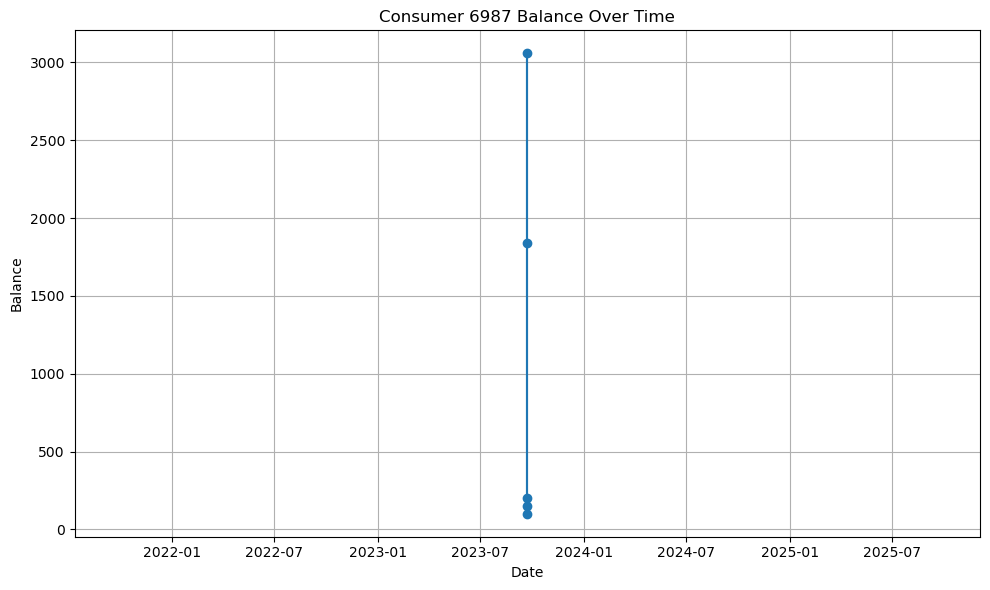

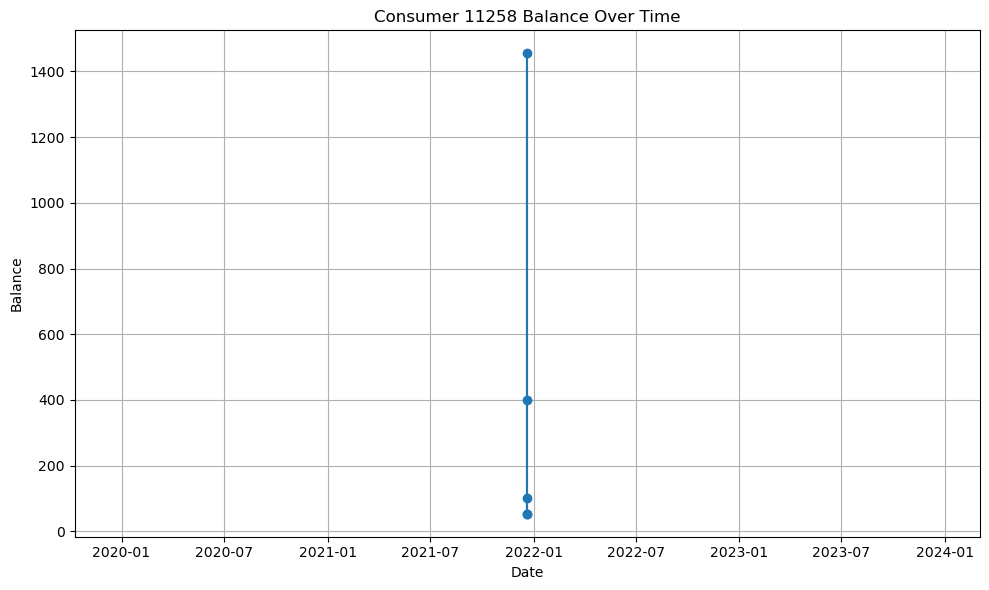

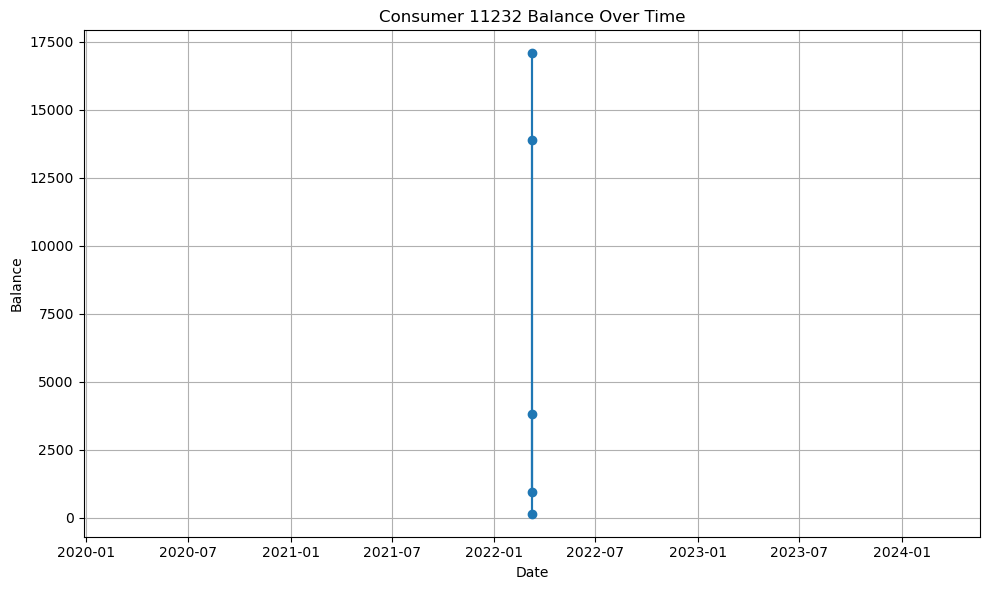

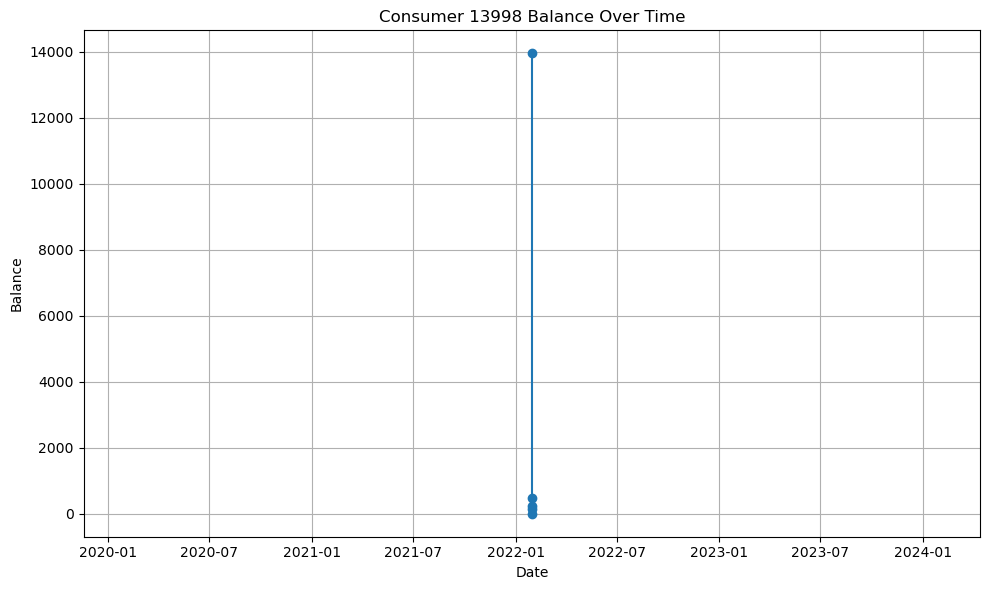

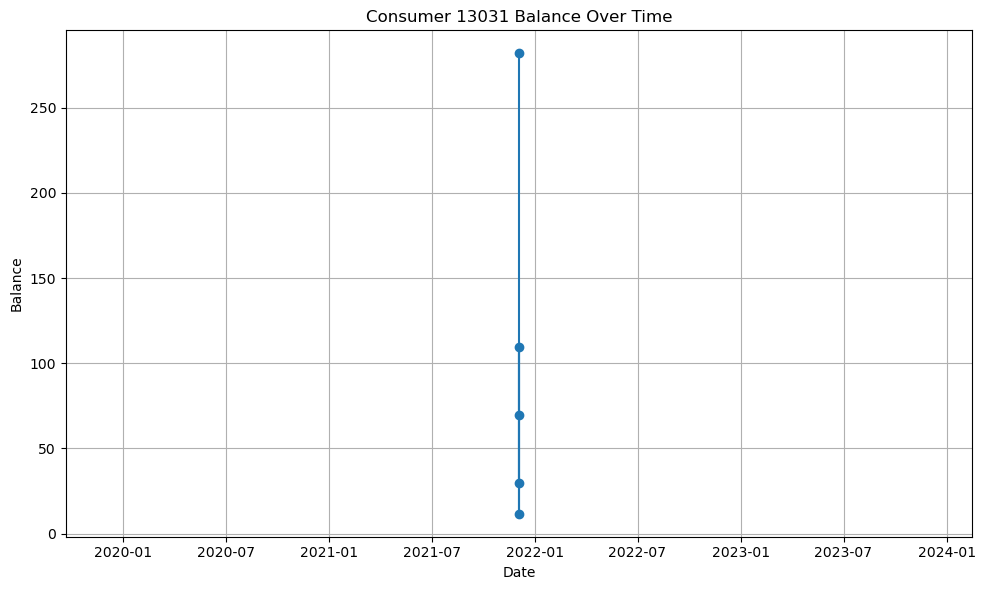

In [33]:
random.seed(100)
plot_balance_for_consumers(cons_acc, 5, 0)

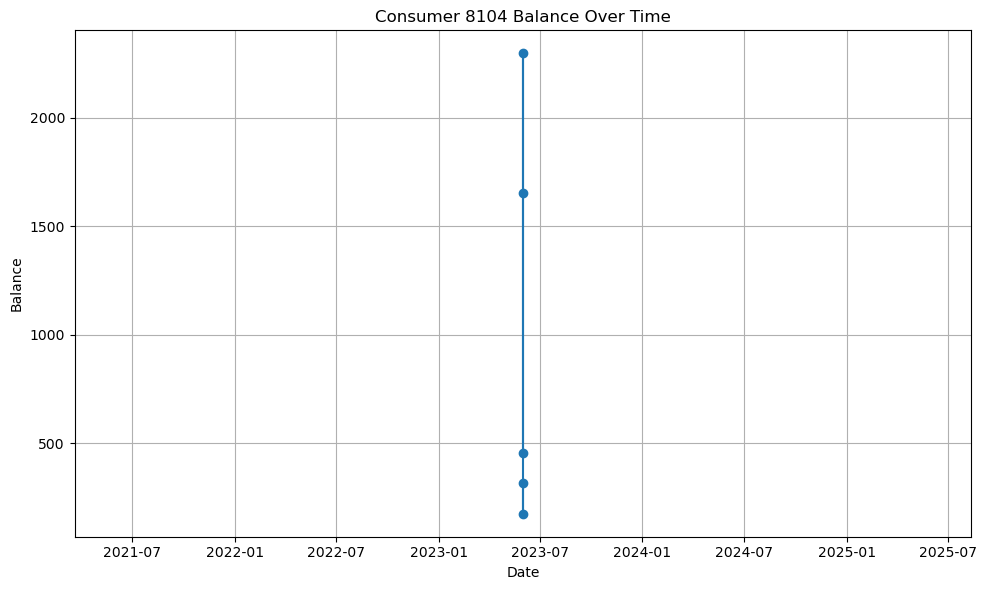

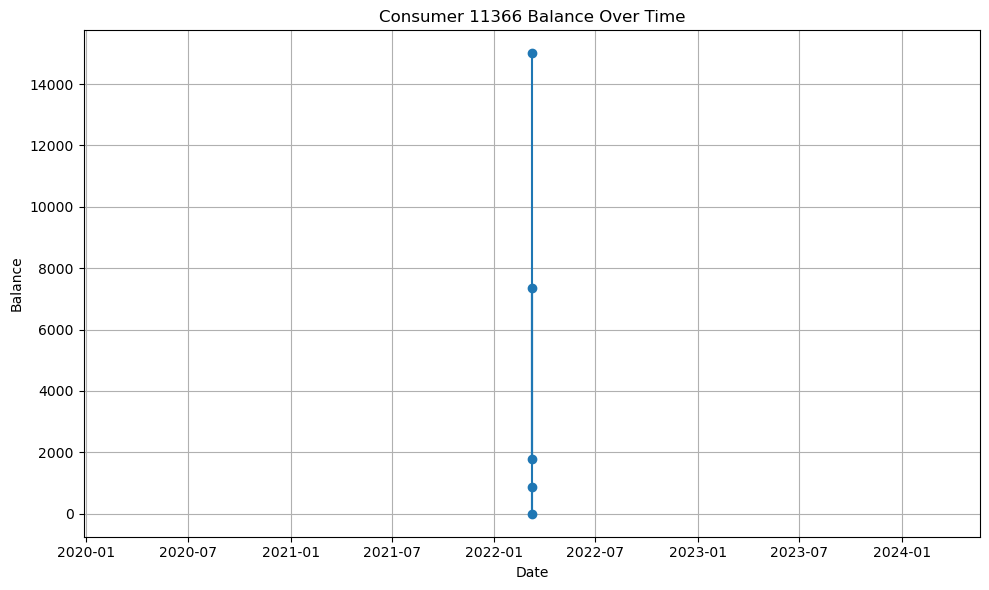

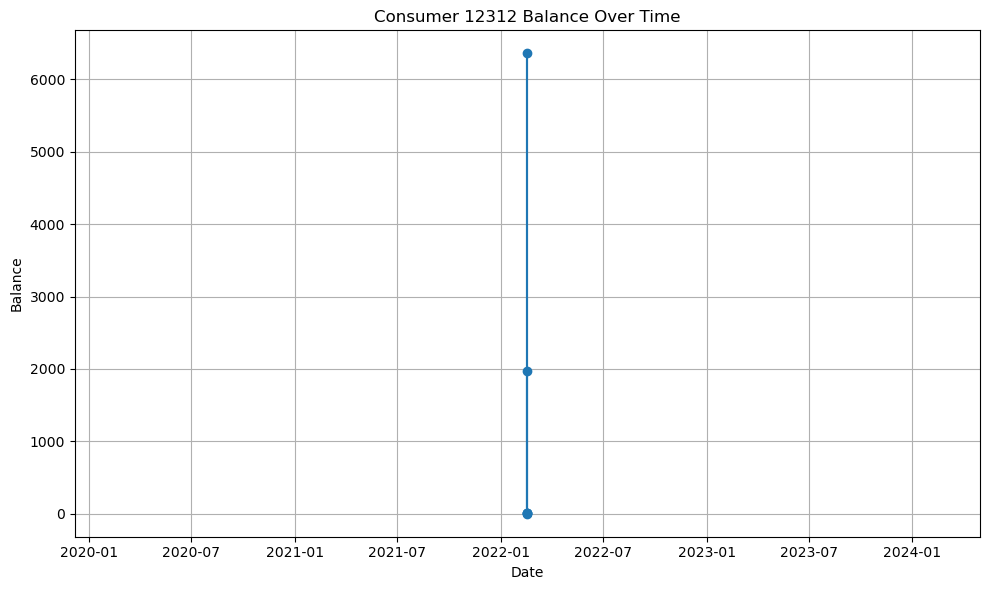

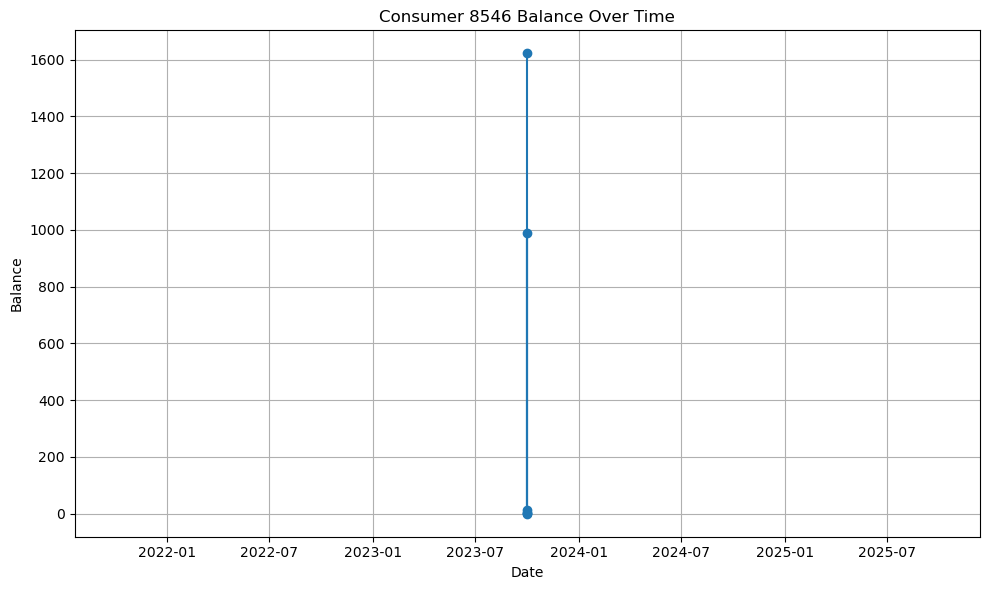

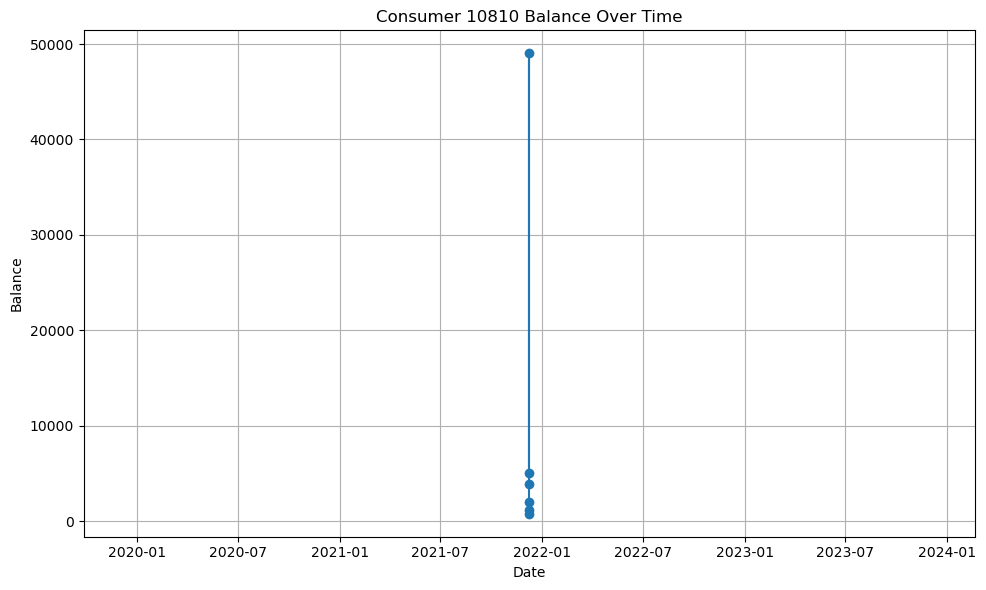

In [34]:
random.seed(100)
plot_balance_for_consumers(cons_acc, 5, 1)

In [41]:
consumers_with_enough_dates = (
        cons_acc.groupby('prism_consumer_id').filter(lambda x: x['balance_date'].nunique() >= 4)['prism_consumer_id'].unique()
    )
consumers_with_enough_dates

array(['2910'], dtype=object)